In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
import cv2
import os
from tensorflow.keras import layers
from time import perf_counter
from tqdm import tqdm
from tensorflow.keras.models import load_model

In [2]:
dataStruct = {
                'categoryNames' : [],
                'ImageArr'      : []
    
}

In [3]:
IMAGE_SIZE = 128
IMAGE_CHANNELS = 3
IMAGE_DIR = 'dataset/'

In [4]:
images_path = IMAGE_DIR 

training_data = []

In [5]:
def dataLoader(path = None, className = None, sizeSquare = 256):
    if path == None:
        return
    i = 0
    images = os.listdir(path)
    for image in images:
        i += 1
        if i == 1001:
            return
        
        loadPath = path + '/' + image
        img = plt.imread(loadPath)
        
        #resizing
        img = cv2.resize(img, (sizeSquare, sizeSquare))
        
        ## adjusting Value between -1 and 1
        img = (img - 127.5)/ 127.5
        dataStruct['categoryNames'].append(className)
        dataStruct['ImageArr'].append(img)

In [6]:
def visualizer():
    plt.figure(figsize = (14, 14))
    numImages = len(dataStruct['ImageArr'])
    randomChoices = np.random.randint(0, numImages, 16)
    
    pltnum = 1
    for choice in randomChoices:
        plt.subplot(4, 4, pltnum)
        plt.imshow(dataStruct['ImageArr'][choice])
        plt.title(dataStruct['categoryNames'][choice])
        pltnum += 1
    
    plt.show()
    return numImages

In [7]:
imgHeight = 256
imgWeigth = 256
latentDim = 100
batchSize = 50

In [8]:
def BuildDescriminator(height = 256, width = 256):
    
    descriminator =  tf.keras.models.Sequential([
    layers.Input(shape = (height, width, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.07),
    layers.Dense(1, activation='sigmoid')
    ])
    
    descriminator.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
    return descriminator

In [9]:
def BuildGenerator (zdims = 100):
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*64*64, use_bias=False, input_shape=(zdims,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((64, 64, 64)))
    
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    
    #print (model.output_shape)
    return model


In [10]:
def MakeCgan (gen, des):
    des.trainable=False
    
    model = tf.keras.Sequential()
    model.add(gen)
    model.add(des)
    opt = tf.keras.optimizers.Adam(lr= 1e-3, beta_1=0.5)   
    
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [11]:
def GanViz (gen):
    noise = np.random.normal(0, 1, (20, 100))
    genImgs = gen.predict(noise)
    genImgs = 0.5*genImgs + 0.5
    pltNum = 1
    
    plt.figure(figsize = (10, 10))
    for i in range(20):
        plt.subplot(5, 4, pltNum)
        imgMerged = cv2.merge((genImgs[i,:,:,0], genImgs[i,:,:,1], genImgs[i,:,:,2]))
        plt.imshow(imgMerged)
        
        pltNum += 1
    
    plt.show()

In [12]:
def Trainer(gen, desc, numImag ,epochs = 1, showAfter = 1):
    
    real = np.ones((batchSize,1))
    fake = np.zeros((batchSize, 1))
    
    strt = perf_counter()
    end =  perf_counter()
    iterNum = 0
    for epoch in tqdm(range(epochs)):
        iterNum += 1
        imgs = []
        ids = np.random.randint(0,numImag, batchSize)
        
        ## taking random samples and appending to arr
        for i in ids :
            imgs.append(dataStruct['ImageArr'][i])
        
        # conveting arr from list to np array
        imgs = np.array(imgs)
        noise = np.random.normal(0,1,(batchSize,100))
        genImgs = gen.predict(noise)
        
        
        ## descriminator training
        dRealLoss = desc.train_on_batch(imgs,real)
        dFakeLoss = desc.train_on_batch(genImgs, fake)
        dloss, dAccuracy = 0.5 * np.add(dRealLoss, dFakeLoss ) 
        
        noise = np.random.normal(0, 1, (batchSize, 100))
        gLoss = cGan.train_on_batch(noise ,real)
        
        if iterNum % showAfter == 0:
            GanViz(gen)
            end = perf_counter()
            print ('generator loss = ' + str(gLoss))
            print ('descriminator loss = ' + str (dloss))
            print ('descriminator Acc = ' + str (dAccuracy))
            print ('Time for this epoch (in minutes) = ' + str ((end - strt)/ 60))
        
       
      
    
    
    return (end - strt)/ 60
            

c:\users\zealottv\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\users\zealottv\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:2834: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for flo

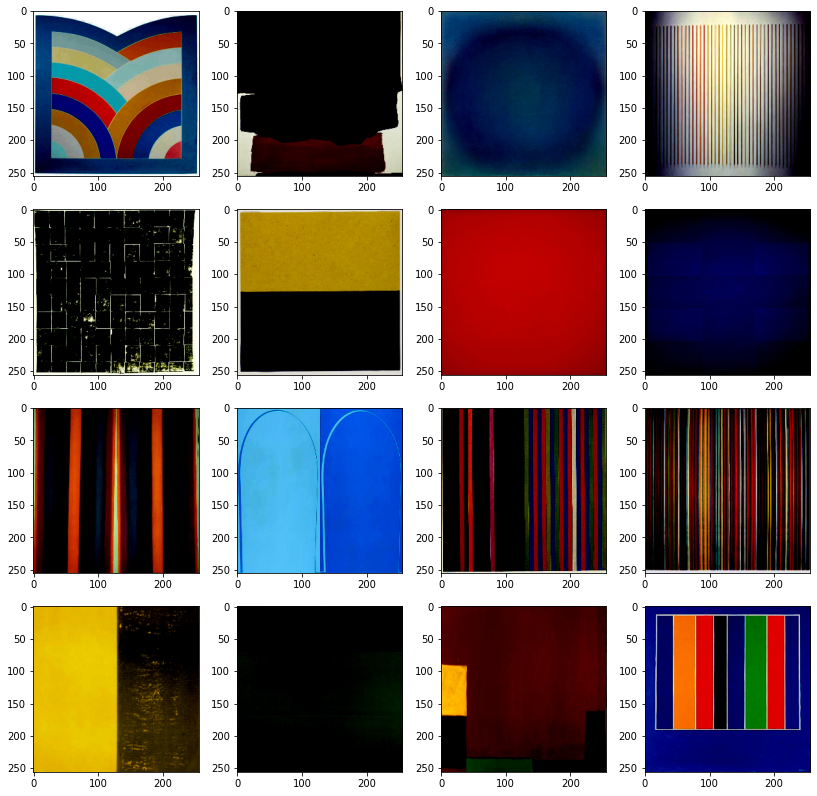

In [13]:
dataLoader(path = './dataset')
numImages = visualizer()

In [14]:
flag = False

In [15]:
desc = BuildDescriminator()
gen = BuildGenerator()
cGan = MakeCgan(gen, desc)

In [16]:
Trainer(gen,desc,numImages,epochs = 400, showAfter = 5)

  0%|                                                                                          | 0/400 [00:09<?, ?it/s]


KeyboardInterrupt: 